In [55]:
from dotenv import load_dotenv

load_dotenv()

True

In [56]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini')

In [57]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

vector_store = Chroma(
    embedding_function=OpenAIEmbeddings(model='text-embedding-3-large'),
    collection_name='real_estate_tax_collections',
    persist_directory='./real_estate_tax_collections'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [58]:
from langchain_core.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever=retriever,
    name='real_estate_tax_retriever',
    description='Contains information about real estate tax up to December 2024'
)

In [59]:
from langchain_tavily import TavilySearch

tavily_search_tool = TavilySearch(
    max_results=5,
    topic="general",
    # include_answer=False,
    # include_raw_content=False,
    # include_images=False,
    # include_image_descriptions=False,
    # search_depth="basic",
    # time_range="day",
    # include_domains=None,
    # exclude_domains=None
)

In [60]:
from langchain_community.tools import ArxivQueryRun
from langchain_community.utilities import ArxivAPIWrapper

arxiv_tool = ArxivQueryRun(api_wrapper=ArxivAPIWrapper(top_k_results=3))

In [61]:
from langchain_google_community import GmailToolkit
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build

# Can review scopes here https://developers.google.com/gmail/api/auth/scopes
# For instance, readonly scope is 'https://www.googleapis.com/auth/gmail.readonly'
SCOPES = [
    "https://www.googleapis.com/auth/gmail.compose",
    "https://www.googleapis.com/auth/gmail.send"
]

flow = InstalledAppFlow.from_client_secrets_file(
    "./google/gmail_credentials.json",
    SCOPES,
)
credentials = flow.run_local_server(port=0)
api_resource = build("gmail", "v1", credentials=credentials)
gmail_toolkit = GmailToolkit(api_resource=api_resource)
gmail_tool_list = gmail_toolkit.get_tools()

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=73320295733-1h8in52ahpt1pcqoclsiuim4em0i207m.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A56800%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fgmail.compose+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fgmail.send&state=2DAGFt2ecDZRuqL8Xv382w7wWFAim8&access_type=offline


In [62]:
tool_list = [retriever_tool, tavily_search_tool, arxiv_tool]
tool_list += gmail_tool_list

In [63]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tool_list)
llm_with_tools = llm.bind_tools(tool_list)

In [64]:
from typing import Literal
from langgraph.graph import MessagesState

class AgentState(MessagesState):
    summary: str
    

In [65]:
from langgraph.types import interrupt, Command

def human_review(state: AgentState) -> Command[Literal['tools', 'agent']]:
    """
    'human_review' Node
    : LLM의 도구 호출에 대해 사용자의 검토를 요청한다.

    Args:
        - state(AgentState): 메시지 상태와 요약을 포함하는 state

    Returns:
        - Command[Literal['tools', 'agent']: 다음 node로 이동하기 위한 Command
    """
    
    messages = state['messages']
    last_ai_message = messages[-1]
    last_tool_call = last_ai_message.tool_calls[-1]
    
    # review
    human_review = interrupt(
        {
            'question': '이렇게 진행하면 될까요?',
            'tool_call': last_tool_call
        }
    )
    review_action = human_review['action']
    review_data = human_review.get('data', None)
    
    ## 에이전트의 판단이 맞다면, 도구를 사용하기 위해 아무것도 수정하지 않고 `tools` 노드로 이동
    if review_action == 'continue':
        return Command(goto='tools')
    
    ## 도구를 더 효율적으로 사용하기 위해 AIMessage의 `tool_calls` 필드를 업데이트
    if review_action == 'update_args':
        update_ai_message = {
            'id': last_ai_message.id,
            'role': 'ai',
            'content': last_ai_message.content,
            'tool_calls': [
                {
                    'id': last_tool_call['id'],
                    'name': last_tool_call['name'],
                    'args': review_data
                }
            ]
        }
        
        return Command(goto='tools', update={'messages': [update_ai_message]})
    
    # 다른 도구를 사용하기 위해 `ToolMessage`를 업데이트
    if review_action == 'update_tool':
        updated_tool_message = {
            'tool_call_id': last_tool_call['id'],
            'role': 'tool',
            'name': last_tool_call['name'],
            'content': review_data
        }
        
        return Command(goto='agent', update={'messages': [updated_tool_message]})
    
    

In [66]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

summarize_prompt = PromptTemplate.from_template(
    """
    아래의 대화 이력을 요약해주세요.
    만일 기존 요약 내용이 있다면, 해당 요약을 포함해 요약해주세요.
    
    [대화 이력]
    {messages}
    
    [기존 요약]
    {summary}
    """
)

def summarize(state: AgentState) -> AgentState:
    """
    'summarize' Node
    : 주어진 상태의 메시지를 요약한다.

    Args:
        - state(AgentState): 메시지 상태와 요약을 포함하는 state

    Returns:
        - AgentState: 응답 메시지를 포함하는 새로운 state
    """
    
    messages = state['messages']
    summary = state['summary']
    
    summarize_chain = summarize_prompt | llm | StrOutputParser()
    ai_message = summarize_chain.invoke({'messages': messages, 'summary': summary})
    
    return {'summary': ai_message}

In [67]:
from langchain_core.messages import RemoveMessage

def delete(state: AgentState) -> AgentState:
    """
    'delete' Node
    : 주어진 상태에서 오래된 메시지를 삭제한다.

    Args:
        - state(AgentState): 메시지 상태와 요약을 포함하는 state

    Returns:
        - AgentState: 오래된 메시지가 삭제된 새로운 state
    """
    
    messages = state['messages']
    
    return {'messages': [RemoveMessage(id=message.id) for message in messages[:-3]]}

In [68]:
from langchain_core.messages import SystemMessage

def agent(state: AgentState) -> AgentState:
    """
    'agent' Node
    : 주어진 상태에서 메시지를 가져와 LLM 및 도구를 사용하여 응답 메시지를 생성한다.

    Args:
        - state(AgentState): 메시지 상태와 요약을 포함하는 state

    Returns:
        - AgentState: 응답 메시지를 포함하는 새로운 state
    """
    
    messages = state['messages']
    summary = state['summary']
    
    if summary != '':
        messages = [SystemMessage(content=f'Here is the summary of the earlier conversation: {summary}')] + messages
    
    ai_message = llm_with_tools.invoke(messages)
    
    return {'messages': [ai_message]}

In [69]:
def should_continue(state: AgentState) -> Literal['human_review', 'summarize']:
    """
    주어진 state에 따라 다음 단계로 진행할지 결정한다.

    Args:
        - state(AgentState): 메시지와 도구 호출 정보를 포함하는 state

    Returns:
        - Literal['human_review', 'summarize']: 다음 단계로 'human_review' 또는 'summarize'를 반환
    """

    messages = state['messages']
    last_ai_message = messages[-1]

    return 'human_review' if last_ai_message.tool_calls else 'summarize'

In [70]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(AgentState)

# nodes
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)
graph_builder.add_node(human_review)
graph_builder.add_node(summarize)
graph_builder.add_node(delete)

# edges
graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    ['human_review', 'summarize'] 
)
graph_builder.add_edge('tools', 'agent')
graph_builder.add_edge('summarize', 'delete')
graph_builder.add_edge('delete', END)

In [71]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()
graph = graph_builder.compile(checkpointer=checkpointer)

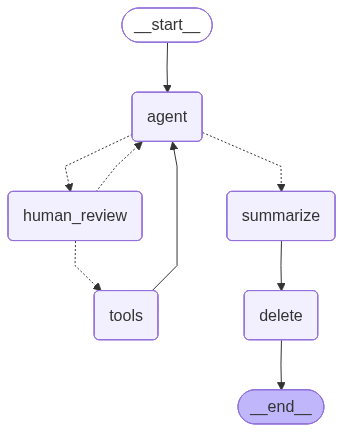

In [72]:
graph

In [73]:
from langchain_core.messages import HumanMessage

query = "LLM Survey 논문의 내용을 검색해서 요약해주세요."
config = {
    'configurable': {
        'thread_id': 'summarize_paper'
    }
}

for chunk in graph.stream({'messages': [HumanMessage(query)], 'summary': ''}, config=config, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

LLM Survey 논문의 내용을 검색해서 요약해주세요.
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_MvjYVxH7UI2WJquDznTRhrJs)
 Call ID: call_MvjYVxH7UI2WJquDznTRhrJs
  Args:
    query: LLM Survey
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_MvjYVxH7UI2WJquDznTRhrJs)
 Call ID: call_MvjYVxH7UI2WJquDznTRhrJs
  Args:
    query: LLM Survey


In [74]:
iter = graph.stream(
    input=Command(resume={
        'action': 'update_args',
        'data': {'query': 'Large Language Model: A Survey'}
    }),
    config=config,
    stream_mode='updates'
)

for chunk in iter:
    print(chunk)

{'human_review': {'messages': [{'id': 'lc_run--019b8ebf-d798-7550-823a-7cc4a2a3fd4b-0', 'role': 'ai', 'content': '', 'tool_calls': [{'id': 'call_MvjYVxH7UI2WJquDznTRhrJs', 'name': 'arxiv', 'args': {'query': 'Large Language Model: A Survey'}}]}]}}
{'tools': {'messages': [ToolMessage(content="Published: 2015-08-17\nTitle: Observation of the rare $B^0_s\\toμ^+μ^-$ decay from the combined analysis of CMS and LHCb data\nAuthors: The CMS, LHCb Collaborations, :, V. Khachatryan, A. M. Sirunyan, A. Tumasyan, W. Adam, T. Bergauer, M. Dragicevic, J. Erö, M. Friedl, R. Frühwirth, V. M. Ghete, C. Hartl, N. Hörmann, J. Hrubec, M. Jeitler, W. Kiesenhofer, V. Knünz, M. Krammer, I. Krätschmer, D. Liko, I. Mikulec, D. Rabady, B. Rahbaran, H. Rohringer, R. Schöfbeck, J. Strauss, W. Treberer-Treberspurg, W. Waltenberger, C. -E. Wulz, V. Mossolov, N. Shumeiko, J. Suarez Gonzalez, S. Alderweireldt, S. Bansal, T. Cornelis, E. A. De Wolf, X. Janssen, A. Knutsson, J. Lauwers, S. Luyckx, S. Ochesanu, R. Rougny

In [75]:
iter = graph.stream(
    input=Command(resume={
        'action': 'update_tool',
        'data': 'arxiv가 아닌 Web으로 검색해주세요.'    
    }),
    config=config,
    stream_mode='updates'
)

for chunk in iter:
    print(chunk)

{'human_review': {'messages': [{'tool_call_id': 'call_iw7jV8dqciWuPt2CCqv5Ypwg', 'role': 'tool', 'name': 'tavily_search', 'content': 'arxiv가 아닌 Web으로 검색해주세요.'}]}}
{'agent': {'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 3630, 'total_tokens': 3660, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 3584}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_29330a9688', 'id': 'chatcmpl-CuggzGknZTpI32mkydU9iSXFZNMYd', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b8ec0-1b11-7743-81d3-eca6a4c76bca-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'Large Language Model Survey paper summary', 'time_range': 'year', 'topic': 'general'}, 'id': 'call

In [76]:
graph.get_state(config).values['messages']

[HumanMessage(content='LLM Survey 논문의 내용을 검색해서 요약해주세요.', additional_kwargs={}, response_metadata={}, id='d3a12467-2514-4de5-8a1d-e2dbb0c264c7'),
 AIMessage(content='', additional_kwargs={}, response_metadata={}, id='lc_run--019b8ebf-d798-7550-823a-7cc4a2a3fd4b-0', tool_calls=[{'name': 'arxiv', 'args': {'query': 'Large Language Model: A Survey'}, 'id': 'call_MvjYVxH7UI2WJquDznTRhrJs', 'type': 'tool_call'}]),
 ToolMessage(content="Published: 2015-08-17\nTitle: Observation of the rare $B^0_s\\toμ^+μ^-$ decay from the combined analysis of CMS and LHCb data\nAuthors: The CMS, LHCb Collaborations, :, V. Khachatryan, A. M. Sirunyan, A. Tumasyan, W. Adam, T. Bergauer, M. Dragicevic, J. Erö, M. Friedl, R. Frühwirth, V. M. Ghete, C. Hartl, N. Hörmann, J. Hrubec, M. Jeitler, W. Kiesenhofer, V. Knünz, M. Krammer, I. Krätschmer, D. Liko, I. Mikulec, D. Rabady, B. Rahbaran, H. Rohringer, R. Schöfbeck, J. Strauss, W. Treberer-Treberspurg, W. Waltenberger, C. -E. Wulz, V. Mossolov, N. Shumeiko, J. Sua

In [77]:
graph.get_state(config).values['summary']

''

In [78]:
iter = graph.stream(
    input=Command(resume={'action': 'continue'}),
    config=config,
    stream_mode='updates'
)

for chunk in iter:
    print(chunk)

{'human_review': None}
{'tools': {'messages': [ToolMessage(content='{"query": "Large Language Model Survey paper summary", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.preprints.org/manuscript/202508.0744", "title": "A Survey of Large Language Models: Evolution ...", "content": "This survey offers an in-depth review of Large Language Models (LLMs), highlighting the significant paradigm shift they represent in artificial intelligence. * **Dataset Contamination and Model Collapse.** Training future LLMs on outputs generated by earlier iterations can result in ’model dementia’ or collapse, a phenomenon where the diversity of human-like language progressively degrades and rare semantic patterns are lost [139]. This survey has examined core aspects of Large Language Model development, covering adaptation techniques, evaluation metrics, diverse applications, economic dynamics, and emerging research trajectories. Wei, J.; Bosma, M.; Zhao, V.Y.; G

In [79]:
graph.get_state(config).values['summary']

'**요약:**  \n\nHuman은 "LLM Survey 논문의 내용을 검색해서 요약해주세요."라고 요청하였고, AI는 여러 검색 도구를 활용하여 관련된 논문들을 찾았다. 그 결과, 다음과 같은 최근의 LLM 관련 설문 조사들을 발견했다:\n\n1. **[A Survey of Large Language Models: Evolution](https://www.preprints.org/manuscript/202508.0744)**:\n   - LLM이 인공지능에서 가져온 중요한 패러다임 변화에 대해 설명.\n   - 데이터 세트 오염 및 "모델 치매"와 같은 문제 다룸.\n\n2. **[Large Language Models in Legal Systems: A Survey](https://www.nature.com/articles/s41599-025-05924-3)**:\n   - 법률 시스템에서의 LLM 응용에 대한 조사.\n\n3. **[A Comprehensive Overview of Large Language Models](https://dl.acm.org/doi/abs/10.1145/3744746)**:\n   - 멀티모달 LLM에 대한 리뷰.\n\n4. **[Evaluating Large Language Models: A Systematic Review](https://www.frontiersin.org/journals/computer-science/articles/10.3389/fcomp.2025.1523699/full)**:\n   - LLM의 효율성 및 다양한 측정 방법을 다룬 체계적인 문헌 검토.\n\n5. **[A Comprehensive Survey on Integrating Large Language Models with Knowledge-Based Methods](https://www.sciencedirect.com/science/article/pii/S0950705125005490)**:\n   - LLM과 지식 기반 시스템의 통합 및